In [ ]:
!pip install -U nolds matplotlib numpy pandas mpld3 statsmodels scikit-learn scipy git+https://github.com/manu-mannattil/nolitsa.git

In [25]:
# %matplotlib inline
import mpld3
mpld3.enable_notebook()
%matplotlib auto
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.spatial import KDTree
from nolitsa import data, delay, dimension, d2, utils
from mpl_toolkits import mplot3d
from statsmodels.tsa.arima_process import arma_generate_sample, arma_acf

os.getcwd()

Using matplotlib backend: Qt5Agg


'd:\\timeserieslab'

In [39]:
def linearfitnrmse(xV, m, Tmax=1, show=False):
    ''' 
    % LINEARFITNRMSE fits an AR model and computes the fitting error
    % for T-step ahead.
    % INPUTS:
    %  xV      : vector of the scalar time series
    %  m       : the embedding dimension.
    %  Tmax    : the prediction horizon, the fit is made for T=1...Tmax steps
    %            ahead.
    %  tittxt  : string to be displayed in the title of the figure 
    %            if not specified, no plot is made
    % OUTPUT: 
    %  nrmseV  : vector of length Tmax, the nrmse of the fit for T-mappings, T=1...Tmax.
    %  phiV    : the coefficients of the estimated AR time series (of length (m+1)
    %            with phi(0) as first component
    '''
    from statsmodels.api import OLS

    n = xV.shape[0]
    mx = np.mean(xV[:n-Tmax+1])
    yV = xV[:n-Tmax+1] - mx
    nvec = n - m - 1 - Tmax
    yM = np.full(shape=(nvec-1, m), fill_value=np.nan)
    for j in np.arange(m):
        yM[:, [m-j-1]] = yV[j:nvec+j-1]
    rV = yV[j+1:nvec+j]
    # np.linalg.lstsq(yM, rV)
    ols = OLS(endog=rV, exog=yM).fit()
    aV = ols.params
    a0 = (1 - np.sum(aV)) * mx
    phiV = np.r_[a0, aV]
    preM = np.full(shape=(n+Tmax-1, Tmax), fill_value=np.nan)
    for i in np.arange(m, n):
        preV = np.full(shape=(m+Tmax, 1), fill_value=np.nan)
        preV[:m] = xV[i-m: i] - mx
        for T in np.arange(1, Tmax+1):
            preV[m + T - 1] = np.dot(aV, (preV[T-1:m+T-1][::-1]))
            preM[i + T - 1, [T-1]] = preV[m + T - 1]
    preM = preM + mx
    nrmseV = np.ones(shape=(Tmax, 1))
    for T in np.arange(1, Tmax+1):
        nrmseV[T-1] = nrmse(xV[m + T - 1:n], preM[m + T - 1: n, [T-1]])
    if show:
        fig, ax = plt.subplots(1, 1)
        ax.plot(np.arange(1, Tmax+1), nrmseV, marker='x')
        ax.set_xlabel('prediction time T')
        ax.set_ylabel('NRMSE(T)')
    return nrmseV, phiV

def localfitnrmse(xV, tau, m, Tmax, nnei, q, show=''):
    '''
     LOCALFITNRMSE makes fitting using a local model of zeroth order (average 
    % mapping or nearest neighbor mappings if only one neighbor is chosen) or a 
    % local linear model and computes the fitting error for T-step ahead. For 
    % the search for neighboring points it uses the Matlab k-d-tree search.
    % The fitting here means that predictions are made for all the points in
    % the data set (in-sample prediction). The prediction error statistic 
    % (NRMSE measure) for the T-step ahead predictions is the goodness-of-fit 
    % statistic. 
    % The state space reconstruction is done with the method of delays having 
    % as parameters the embedding dimension 'm' and the delay time 'tau'. 
    % The local prediction model is one of the following:
    % Ordinary Least Squares, OLS (standard local linear model): if the 
    % truncation parameter q >= m
    % Principal Component Regression, PCR, project the parameter space of the 
    % model to only q of the m principal axes: if 0<q<m
    % Local Average Mapping, LAM: if q=0.
    % The local region is determined by the number of neighbours 'nnei'. 
    % The k-d-tree data structure is utilized to speed up computation time in 
    % the search of neighboring points and the implementation of Matlab is 
    % used. 
    % INPUTS:
    %  xV      : vector of the scalar time series
    %  tau     : the delay time (usually set to 1).
    %  m       : the embedding dimension.
    %  Tmax    : the prediction horizon, the fit is made for T=1...Tmax steps
    %            ahead.
    %  nnei    : number of nearest neighbors to be used in the local model. 
    %            If k=1,the nearest neighbor mapping is the fitted value. 
    %            If k>1, the model as defined by the input patameter 'q' is
    %            used. 
    %  q       : the truncation parameter for a normalization of the local
    %            linear model if specified (to project the parameter space of
    %            the model, using Principal Component Regression, PCR, locally).
    %            if q>=m -> Ordinary Least Squares, OLS (standard local linear
    %                       model, no projection)
    %            if 0<q<m -> PCR(q)
    %            if q=0 -> local average model (if in addition nnei=1 ->
    %            then the zeroth order model is applied)
    %  tittxt  : string to be displayed in the title of the figure 
    %            if not specified, no plot is made
    % OUTPUT: 
    %  nrmseV  : vector of length Tmax, the nrmse of the fit for T-mappings, 
    %            T=1...Tmax.
    %  preM    : the matrix of size nvec x (1+Tmax) having the fit (in-sample
    %            predictions) for T=1,...,Tmax, for each of the nvec 
    %            reconstructed points from the whole time series. The first
    %            column has the time of the target point and the rest Tmax
    %            columns the fits for T=1,...,Tmax time steps ahead.
    '''
    if q > m:
        q = int(m)
    n = xV.shape[0]

    if n < 2 * (m-1)*tau - Tmax:
        print('too short timeseries')
        return

    nvec = n - (m-1)*tau - Tmax
    xM = np.full(shape=(nvec, m), fill_value=np.nan)

    for j in np.arange(m):
        xM[:, [m-j-1]] = xV[j*tau:nvec+j*tau]
    from scipy.spatial import KDTree
    kdtreeS = KDTree(xM)
    preM = np.full(shape=(nvec, Tmax), fill_value=np.nan)
    _, nneiindM = kdtreeS.query(xM, k=nnei+1, p=2)
    nneiindM = nneiindM[:, 1:]
    for i in np.arange(nvec):
        neiM = xM[nneiindM[i]]
        yV = xV[nneiindM[i] + m*tau]
        if q == 0 or nnei == 1:
            preM[i, 0] = np.mean(yV)
        else:
            mneiV = np.mean(neiM, axis=0)
            my = np.mean(yV)
            zM = neiM - mneiV
            [Ux, Sx, Vx] = np.linalg.svd(zM, full_matrices=False)
            Sx = np.diag(Sx)
            Vx = Vx.T
            tmpM = Vx[:, :q] @ (np.linalg.inv(Sx[:q, :q]) @ Ux[:, :q].T)
            lsbV = tmpM @ (yV - my)
            preM[i] = my + (xM[i, ] - mneiV) @ lsbV
    if Tmax > 1:
        winnowM = np.full(shape=(nvec, (m - 1) * tau + 1), fill_value=np.nan)
        for i in np.arange(m*tau):
            winnowM[:, [i]] = xV[i:nvec+i]
        for T in np.arange(2, Tmax+1):
            winnowM = np.concatenate([winnowM, preM[:, [T-2]]], axis=1)
            targM = winnowM[:, :-(m+1)*tau:-tau]
            _, nneiindM = kdtreeS.query(targM, k=nnei, p=2)

            for i in np.arange(nvec):
                neiM = xM[nneiindM[i], :]
                yV = xV[nneiindM[i] + (m-1)*tau+1]
                if q == 0 or nnei == 1:
                    preM[i, T-1] = np.mean(yV)
                else:
                    mneiV = np.mean(neiM, axis=0)
                    my = np.mean(yV)
                    zM = neiM - mneiV
                    [Ux, Sx, Vx] = np.linalg.svd(zM, full_matrices=False)
                    Sx = np.diag(Sx)
                    Vx = Vx.T
                    tmpM = Vx[:, :q] @ (np.linalg.inv(Sx[:q, :q]) @ Ux[:, :q].T)
                    lsbV = tmpM @ (yV - my)
                    preM[i, T-1] = my + (targM[i, :] - mneiV) @ lsbV

    nrmseV = np.full(shape=(Tmax, 1), fill_value=np.nan)
    idx = (np.arange(nvec) + (m-1)*tau).astype(np.int)
    for t_idx in np.arange(1, Tmax+1):
        nrmseV[t_idx-1] = nrmse(trueV=xV[idx + t_idx, ], predictedV=preM[:, [t_idx-1]])
    if show:
        fig, ax = plt.subplots(1, 1)
        ax.plot(np.arange(1, Tmax+1), nrmseV, marker='x')
        ax.set_xlabel('prediction time T')
        ax.set_ylabel('NRMSE(T)')
    return nrmseV, preM

def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')
            
def ANN(X, k):
    '''
    helper func
    '''
    tree = KDTree(X, leaf_size=1, metric='chebyshev')
    dists, nnidx = tree.query(X, k=k)
    del tree
    return nnidx, dists

def ANNR(X, rV):
    '''
    helper func
    '''
    tree = KDTree(X, leaf_size=1, metric='chebyshev')
    nnnidx = tree.query_radius(X, r=rV, count_only=True)
    return nnnidx

def nneighforgivenr(X, rV):
    '''
    helper func
    '''
    npV = ANNR(X, rV)
    npV[npV == 0] = 1
    return npV


def mi_estimator_ksg1(xV, yV, nnei=5, normalize=False):
    '''
    calculates I(X;Y) using KSG algorithm1 (with max-norms squares)
    '''
    from scipy.special import psi

    n = xV.shape[0]
    psi_nnei = psi(nnei)
    psi_n = psi(n)

    if normalize:
        xV = (xV - np.min(xV)) / np.ptp(xV)
        yV = (yV - np.min(yV)) / np.ptp(yV)

    xembM = np.concatenate((xV, yV), axis=1)
    _, distsM = ANN(xembM, nnei + 1)
    maxdistV = distsM[:, -1]
    n_x = nneighforgivenr(X=xV, rV=maxdistV - np.ones(n) * 10 ** (-10))
    n_y = nneighforgivenr(X=yV, rV=maxdistV - np.ones(n) * 10 ** (-10))
    psibothM = psi(np.concatenate((n_x.reshape(-1, 1), n_y.reshape(-1, 1)), axis=1))
    #     # I(X;Y) = ψ(k) + ψ(Ν) - <ψ(Nx + 1) + ψ(Ny + 1)>
    mi = psi_nnei + psi_n - np.mean(np.sum(psibothM, axis=1))
    return mi

def falsenearestneighbors(xV, m_max=10, tau=1, show=False):
    dim = np.arange(1, m_max + 1)
    f1, _, _ = dimension.fnn(xV, tau=tau, dim=dim, window=10, metric='cityblock')
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.scatter(dim, f1)
        ax.axhline(0.01, linestyle='--', color='red', label='1% threshold')
        ax.set_xlabel(f'm')
        ax.set_title(f'FNN ({m_max})')
        ax.set_xticks(dim)
        ax.legend()
        plt.show()
    return f1

def correlationdimension(xV, tau, mmax, fac=4, logrmin=-1e6, logrmax=1e6, show=False):
    m_all = np.arange(1, m_max + 1)
    corrdimV = []
    logrM = []
    logCrM = []
    polyM = []

    for m in m_all:
        corrdim, *corrData = nolds.corr_dim(xV, m, debug_data=True)
        corrdimV.append(corrdim)
        logrM.append(corrData[0][0])
        logCrM.append(corrData[0][1])
        polyM.append(corrData[0][2])
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(m_all, corrdimV, marker='x', linestyle='.-')
        ax.set_xlabel('m')
        ax.set_xticks(m_all)
        ax.set_ylabel('v')
        ax.set_title('Corr Dim vs m')
        
        
    return corrdimV, logrM, logCrM, polyM
       
def split2train_testset(xV, test_proportion):
    n = np.int(len(xV) * test_proportion)
    return xV[:n], xV[n:]

    
def plot_3d_attractor(xM):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xM[:, 0], xM[:, 1], xM[:, 2])
    ax.plot(xM[:, 0], xM[:, 1], xM[:, 2], linestyle='--')
    plt.show()

def embed_data(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

def logisticmap(n=1024, r=3., x0=None):
    ntrans = 10
    xV = np.full(shape=(n+ntrans, 1), fill_value=np.nan)
    if x0 is None:
        xV[0] = np.random.uniform(low=0, high=2.9)
    else:
        xV[0] = x0
    for t in np.arange(1, n+ntrans):
        xV[t] = r * xV[t-1] * (1 - xV[t-1])
    xV = xV[ntrans:, [0]]
    return xV.reshape(-1, )

def generate_arma_ts(phiV, thetaV, n, sdnoise=1):
    '''
    Generate an ARMA(p,q) time series of length 'n' with Gaussian input noise.
    Note that phiV = [phi(0) phi(1) ... phi(p)]' and phi(0) is the constant
    term, and thetaV = [theta(1) ... theta(q)]'.
    sdnoise is the SD of the input noise (if left out then sdnoise=1).
    The generating ARMA(p,q) process reads
    x(t) = phi(0) + phi(1)*x(t-1) + ... + phi(p)*x(t-p) +
            +z(t) - theta(1)*z(t-1) + ... - theta(q)*z(t-p),
    z(t) ~ WN(0,sdnoise^2)
    '''
    phiV = np.array(phiV)
    thetaV = np.array(thetaV)
    ar_params = np.r_[1, -phiV[:]]  # add zero lag
    ma_params = np.r_[1, thetaV[:]]  # add zero lag
    xV = arma_generate_sample(ar=ar_params, ma=ma_params, nsample=n, scale=sdnoise, burnin=100)
    return xV
   

In [ ]:
n = 100
x0 = 0.51
r = 3.9
xV = logisticmap(n=n, r=r, x0=x0)
plt.figure()
plt.plot(xV)

In [ ]:
embedded = embed_data(xV, order=2, delay=1)
# embedded;
plt.scatter(xV[:-1], xV[1:])

In [ ]:
xV = generate_arma_ts([0.8], [0], n)
plt.plot(xV);
plt.show();

In [ ]:
embedded = embed_data(xV, order=2, delay=1)
# embedded;
plt.scatter(xV[:-1], xV[1:])

In [ ]:
xM = data.henon();
xM, xM.shape
plt.plot(xM);

In [ ]:
plt.figure(figsize=(14, 8))
xM = xM[:, 0]
plt.plot(xM);

In [ ]:
embedded = embed_data(xM, order=3, delay=1)
embedded
plot_3d_attractor(embedded)

## REAL DATA ATTRACTORS

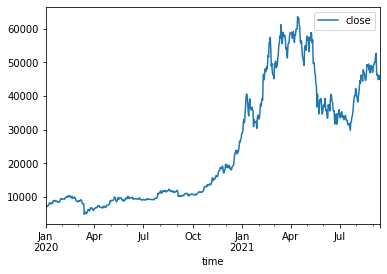

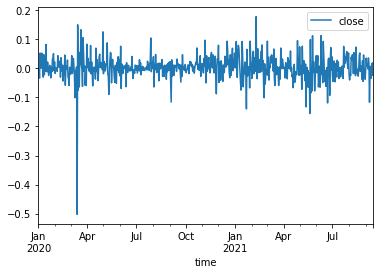

In [4]:
os.chdir('d:/timeserieslab/')
df = pd.read_csv('./data/BTCUSDT.csv')
df.set_index(pd.to_datetime(df['time']), inplace=True)
df.drop('time', axis=1, inplace=True)
df = df['01-01-2020':'12-31-2021']
df.plot();
logreturns = df.apply(lambda x: np.log(x)).diff().bfill()
logreturns.plot();

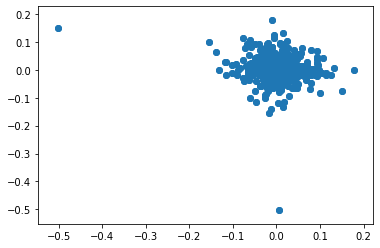

In [12]:
embedded = embed_data(logreturns.values.reshape(-1,), order=2, delay=1)
plt.scatter(embedded[:-1], embedded[1:]);

In [40]:
eeg = pd.read_csv('./data/epileeg.dat')
# eeg.plot();
embedded = embed_data(eeg.values.reshape(-1,), order=3, delay=1)
plot_3d_attractor(embedded)
#plt.scatter(embedded[:-1], embedded[1:], linestyle='--', marker='x');

## Check for stationarity (Visual Inspection + statistical test)

In [ ]:
xM = xM[2900:3000]
plt.figure(figsize=(14, 8))
plt.plot(xM);

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(xM, maxlag=None)
print(adf)

## Compute autocorrelation and delayed mutual information.


In [ ]:
print(dir(delay))
help(delay.acorr)
xM.shape

In [ ]:
maxtau = 10
lag = np.arange(maxtau)
r = delay.acorr(xM, maxtau=maxtau)
i = delay.dmi(xM, maxtau=maxtau)
r_delay = np.argmax(r < 1.0 / np.e)

plt.figure(1, figsize=(14, 8))

plt.subplot(211)
plt.title(r'Delay estimation for Henon map')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, i, marker='o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, r, r_delay, r[r_delay], 'o')
plt.axhline(1.0 / np.e, linestyle='--', alpha=0.7, color='red' )


plt.figure(2, figsize=(14, 8))
plt.subplot(111)
plt.title(r'Time delay = %d' % r_delay)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t + \tau)$')
plt.plot(xM[:-r_delay], xM[r_delay:], '.')

plt.show()
print(r)
print(r'Autocorrelation time = %d' % r_delay)

In [ ]:
dim = np.arange(1, 10 + 1)
f1, f2, f3 = dimension.fnn(xM, tau=1, dim=dim, window=10, metric='cityblock')

In [ ]:
plt.title(r'FNN for Henon map')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

plt.show()

## Correlation Sum

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('Local $D_2$ vs $r$ for Henon map')
plt.xlabel(r'Distance $r$')
plt.ylabel(r'Local $D_2$')
theiler_window = 10
tau = 1
dim = np.arange(1, 10 + 1)

for r, c in d2.c2_embed(xM, tau=tau, dim=dim, window=theiler_window,
                        r=utils.gprange(0.001, 1.0, 100)):
    plt.semilogx(r[3:-3], d2.d2(r, c), color='#4682B4')

plt.semilogx(utils.gprange(0.001, 1.0, 100), 1.220 * np.ones(100),
             color='#000000')
plt.show()

In [ ]:
r = n_utils.gprange(0.001, 1.0, 100)
corr_dim, debug_data = nolds.corr_dim(xM, emb_dim=2, rvals=r, debug_data=True)

In [ ]:
rvals = debug_data[0] #values used for log(r)
csums = debug_data[1] #the corresponding log(C(r))
poly = debug_data[2] #line coefficients ([slope, intercept])


In [ ]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.plot(rvals, csums)
ax.set_xlabel('log(r)')
ax.set_ylabel('log(C(r))')

## Predictions
- LAP
- LLP

In [ ]:
n = xM.shape[0]
test_prop = 0.3
split_point = int(n * (1 - test_prop))

In [ ]:
train_xM = xM[:split_point]
test_xM = xM[split_point:]

plt.figure(figsize=(16, 8))
plt.plot(np.arange(split_point), train_xM, color='blue', alpha=0.7, label='train set');
plt.plot(np.arange(split_point, xM.shape[0]), test_xM, color='red', linestyle='--', alpha=0.7, label='test set');
plt.legend()
plt.xlabel('Time');
plt.ylabel('Value');

In [ ]:
from sklearn.neighbors import KDTree
embed_train_data = embed_data(train_xM, 2, 1)
embed_test_data = embed_data(test_xM, 2, 1)


In [ ]:
knn = 5
tree = KDTree(embed_train_data, leaf_size=1, metric='chebyshev')
neighbors_idx = []
for i, state in enumerate(embed_test_data):
    dist, neigh_idx = tree.query(state.reshape(1, -1), k=knn)
    neighbors_idx.append(tuple([i, neigh_idx[0]]))


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(xM)
plt.xlabel('time')
plt.ylabel('xM')
plt.axvline(split_point, linestyle='--', color='black', alpha=0.5)
# #get neighbors of first test datapoint  
check_test_point = 1
neigh = neighbors_idx[check_test_point]
print(neigh)
test_state_idx = neigh[0]
neighs_idx = neigh[1]
plt.plot([neighs_idx, neighs_idx+1], [xM[neighs_idx], xM[neighs_idx+1]], linestyle='--', color='orange' )
plt.scatter([neighs_idx, neighs_idx+1], [xM[neighs_idx], xM[neighs_idx+1]], linestyle='--', color='orange')
# #test set state
plt.plot([test_state_idx+split_point, test_state_idx+split_point+1], [xM[test_state_idx+split_point], xM[test_state_idx+split_point+1]], linestyle='--', color='red' )
plt.scatter([test_state_idx+split_point, test_state_idx+split_point+1], [xM[test_state_idx+split_point], xM[test_state_idx+split_point+1]], linestyle='--', color='red')
    
plt.figure(figsize=(16, 8))
plt.scatter(embed_train_data[:, 0], embed_train_data[:, 1], alpha=0.3)
plt.scatter(embed_train_data[neighs_idx][:, 0], embed_train_data[neighs_idx][:, 1], label=f'neighbors in train data')
plt.scatter(embed_test_data[test_state_idx, 0], embed_test_data[test_state_idx, 1], label=f'test point:{test_state_idx}')
plt.xlabel('x(t)')
plt.ylabel('x(t+1)')
plt.legend()


In [ ]:
T = 1;
lap_predictions = []
for neigh in neighbors_idx:
    test_state_idx = neigh[0]
    neighs_idx = neigh[1]
    images_idx = neighs_idx + T
    images = xM[images_idx]
    lap = np.sum(images) / len(images)
    lap_predictions.append(lap)
plt.figure(figsize=(14, 8))
plt.plot(np.arange(split_point+1, xM.shape[0]), lap_predictions, label='LAP prediction', alpha=0.9, linestyle='-.')
plt.plot(np.arange(split_point+1, xM.shape[0]), test_xM[1:,], label='True values', alpha=0.9, linestyle='--')

In [ ]:
np.sqrt(np.mean((np.array(lap_predictions) -  test_xM[1:,])**2))/np.std(test_xM[1:,])

In [ ]:
X, y = [], []
for neigh in neigh_idx:
    x_ =  [xM[neigh], xM[neigh+1]]
    y_ = [xM[neigh+1+T]]
    X.append(x_)
    y.append(y_)
import statsmodels.api as sm
X = sm.add_constant(X)
X = np.asarray(X)
y = np.asarray(y)
ols = sm.OLS(endog=y, exog=X).fit()
llp = np.dot(ols.params, [1, xM[i+split_point], xM[i+split_point+1]])
ols.summary()


## Real Data

In [ ]:
with open('epileeg.dat', 'r') as file:
    lines = file.readlines()
xM = np.full(shape=len(lines), fill_value=np.nan)
for i, line in enumerate(lines):
    point = line.rstrip().lstrip()
    xM[i] = point
xM = np.array(xM)
xM
plt.plot(xM)
plt.show()